<a href="https://colab.research.google.com/github/sanjeetarya001/TimeSeriesdata/blob/main/smoothing_time_series_walk_through.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smoothing Financial Time Series with Wavelets: Real-life Use Case and Example

Code authored by: Shawhin Talebi

#### Goal:
My goal with this walk-through is to showcase what data science projects look like in the "real-world". While this is a simple use case, the data and problem are from reality (as opposed to a classroom). Here I will walk through the problem, break down different solutions, and share my thoughts along the way.

#### Import modules + data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, ifft
import pywt

In [ ]:
path = 'https://github.com/sanjeetarya001/TimeSeriesdata/raw/main/output.csv'
df = pd.read_csv(path)
df = df.tail(3000)

In [ ]:
x = df.index
y = df['price']

## Background
A friend of mine is working on a project to automatically trade cryptocurrencies. He has some strategy (I don't know the details) that uses the time series plotted below to make buy/sell decisions. He reached out to me because his strategy was giving undesirable results due to the volatility of the time series.

Initial thoughts:
- What is this data?
- Why do you need to use this particular time series?
- Is an alternative strategy using different data possible?

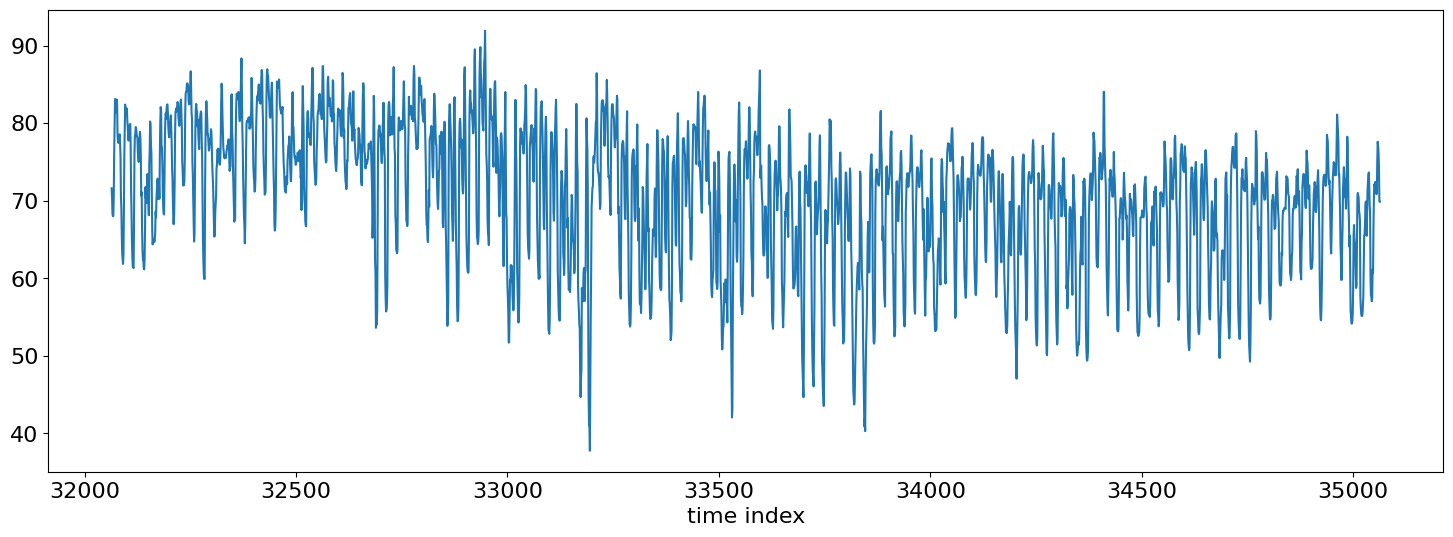

In [ ]:
plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 16})

plt.plot(x ,y)
plt.xlabel('time index')
plt.show()

## Solutions

### Existing Solution: Moving Average
My first thought would be to simply apply a moving average to the data. It turns out my friend had already tried this.

While at first glance this seems to do a fine job, this did not fully resolve the problem. Without knowing too much about the details of his technique I see 3 possible issues:
1. The signal still shows rapid changes in particular sections
2. There are time shifting artifacts from moving average
3. Optimal window size for the moving average is likely dynamic

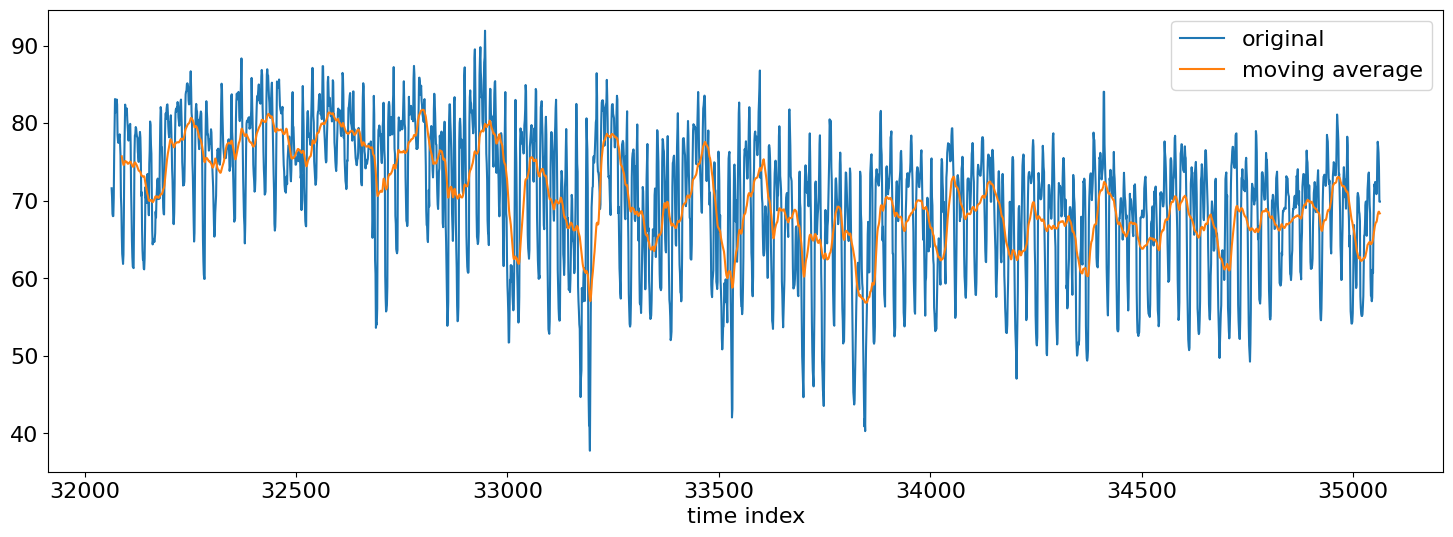

In [ ]:
window=25
y_ma = y.rolling(window).mean()

plt.figure(figsize=(18,6))

plt.plot(x ,y, x, y_ma)
plt.legend(['original', 'moving average'])
plt.xlabel('time index')
plt.show()

### 1st Attempt: Polynomial Fit (failed)

I interpreted this as an approximation problem. In other words, we have some function and we want to approximate it in such a way that we only keep the most relevant properties. When I think "function", my first thought is polynomial. So the idea then became, fit the data to a polynomial and keep only the "most relevant" terms.

This is a good example of when expectations and intuitions fail. I was so confident this quick and easy fix would work, the project seemed trivial. While this solution was indeed quick, it definitely did not work out as expected.

In [ ]:
deg=15

z = np.polyfit(x, y, deg)
p = np.poly1d(z)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


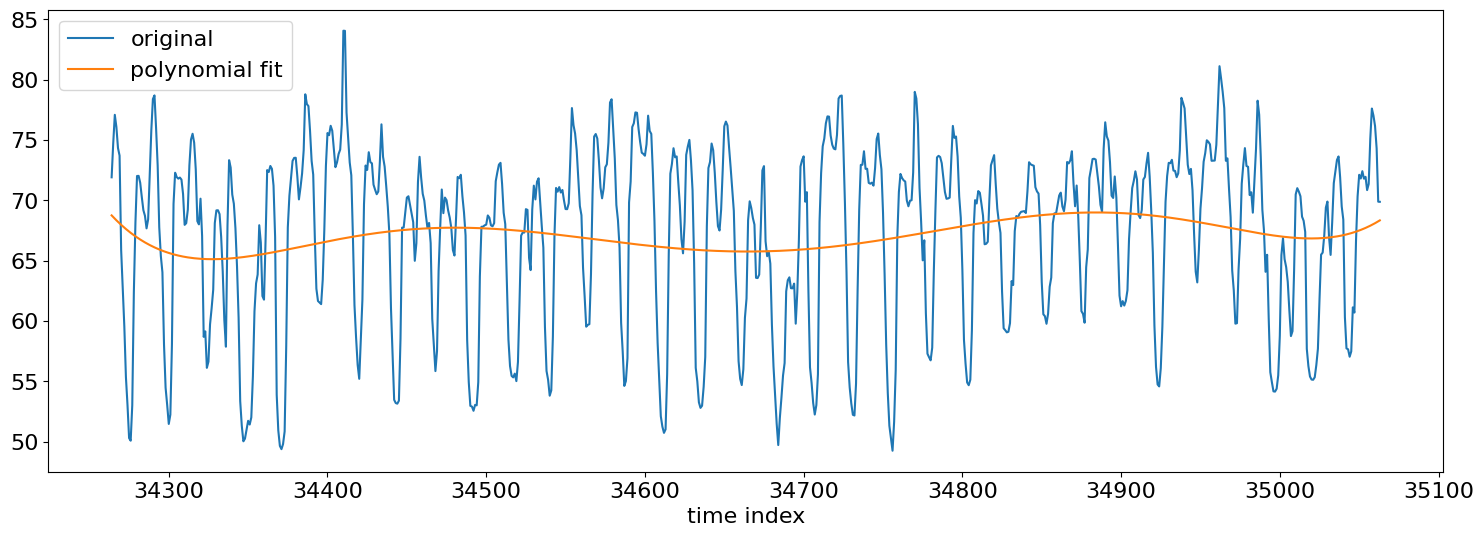

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(x ,y, x, p(x))
plt.legend(['original', 'polynomial fit'])
plt.xlabel('time index')
plt.show()

### 2nd Attempt: Fourier Transform (failed)

Next I thought, of course polynomials don't work they want to go to -$\infty$ and +$\infty$. The data here seem to oscillate around zero. This made me think of sines and cosines. The idea was thus, fit the data to a family of cosine and sine functions, then drop higher order terms, just like I did with the polynomials.

While sinusoidal fits exist, it often makes more sense to reframe the problem in terms of a Fourier Transform. This is for practical reasons because we can use the computationally efficient and widely-used Fast Fourier Transform. So the idea then became, to decompose the signal using a Fourier Transform, then keep only coefficients above a certain threshold.

This worked to some extent but I'd say the moving average solution is both simpler and qualitatively better. Two keys issues I see with the FT solution are:
1. The signal is still pretty noisy
2. The optimal coefficient threshold may be dynamic

In [ ]:
y_fft = fft(y.to_numpy())

power = np.abs(y_fft/len(y))
y_fft[power<0.99] = 0

y_inv = ifft(y_fft)

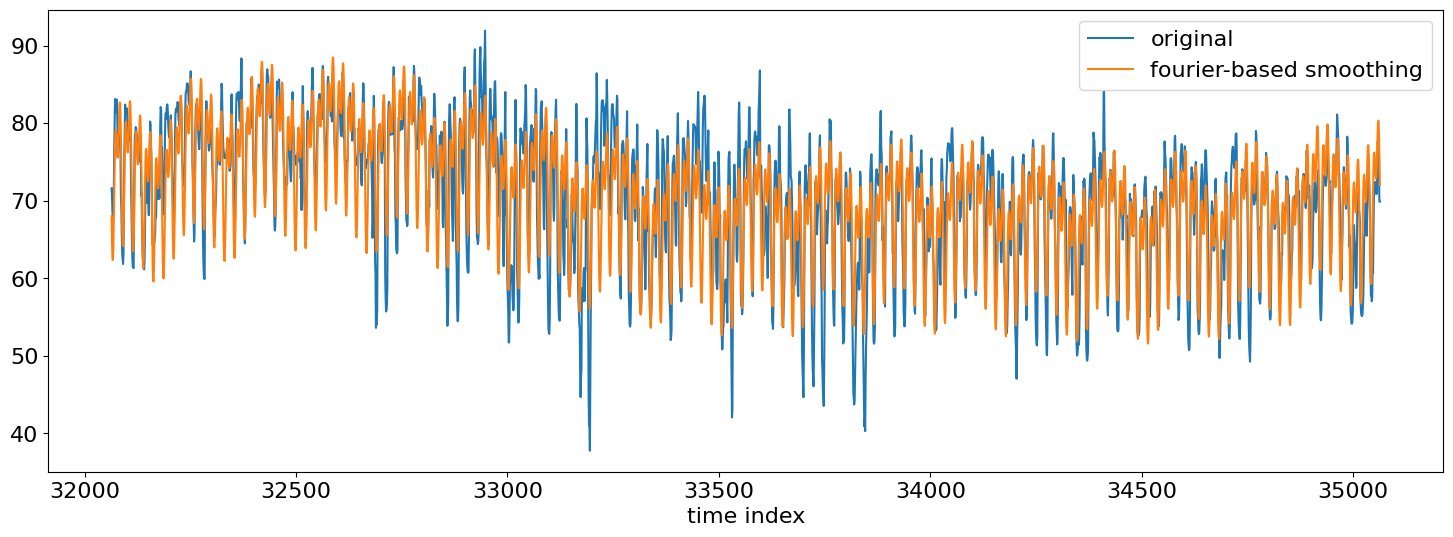

In [ ]:
# plt.plot(y_inv)
plt.figure(figsize=(18,6))
plt.plot(x ,y, x, y_inv)
plt.legend(['original', 'fourier-based smoothing'])
plt.xlabel('time index')
plt.show()

### Final Solution: Wavelet Decomposition
Fourier-based approaches rely on sinusoids that extend from -$\infty$ to +$\infty$ (on the x-axis now). While this can be a feature of the technique, in this case, I'd say it's an issue.
My intuition for this is that the time series may have a variety of regimes, where the underlying generator of the signal is changing over time. What this would translate to is behavior that appears in one time range but not others. Such localized oscillations bring up the concept of a wavelet, which is essentially a wave-like thing that is localized in time.

So, here we try an analogous approach to the previous solutions, but instead of decomposing the data to a family of polynomials or sinusoids, we use wavelets.

The result seems to be a nice balance of capturing the dynamics of the underlying signal, but foregoing much of the volatility.

In [ ]:
# perform wavelet decomposition
coeffs = pywt.wavedec(y, 'sym5', mode='symmetric')

In [ ]:
len(coeffs)

9

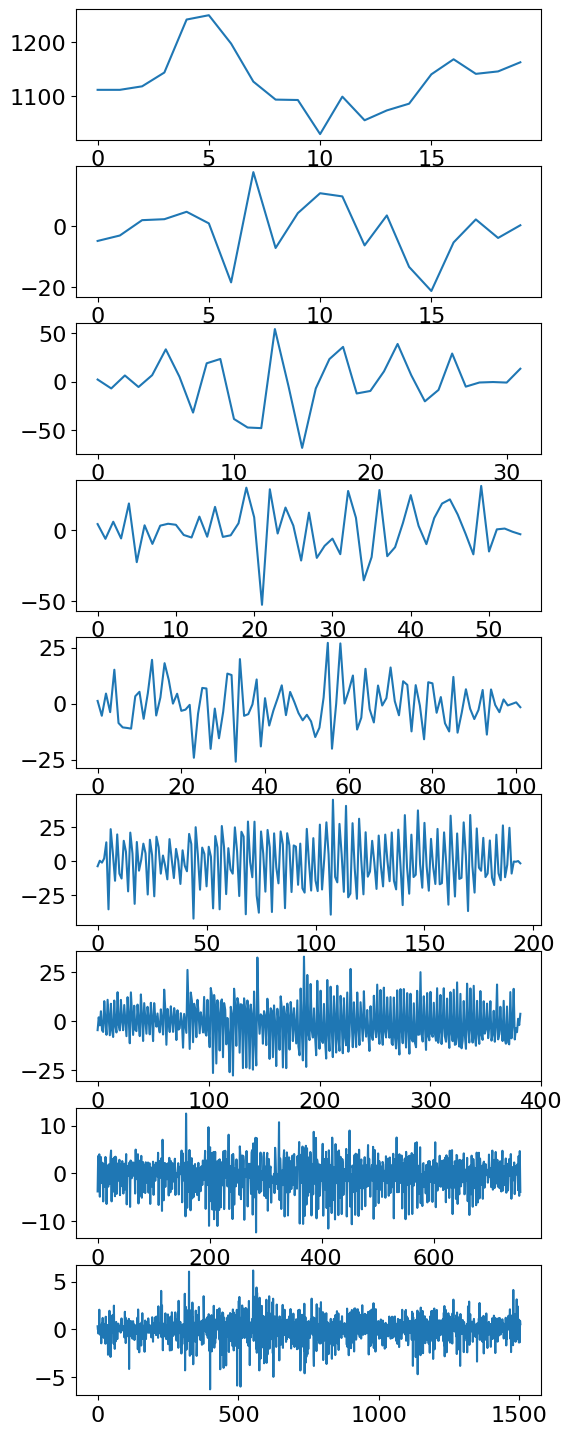

In [ ]:
# plot wavelet decompositions

plt.figure(figsize=(6,18))

for i in range(len(coeffs)):
    plt.subplot(len(coeffs),1, i+1)
    plt.plot(coeffs[i])

In [ ]:
# zero out last 5 detail coefficents
for i in range(5):
    coeffs[i+5] = np.zeros(coeffs[i+5].shape)

IndexError: ignored

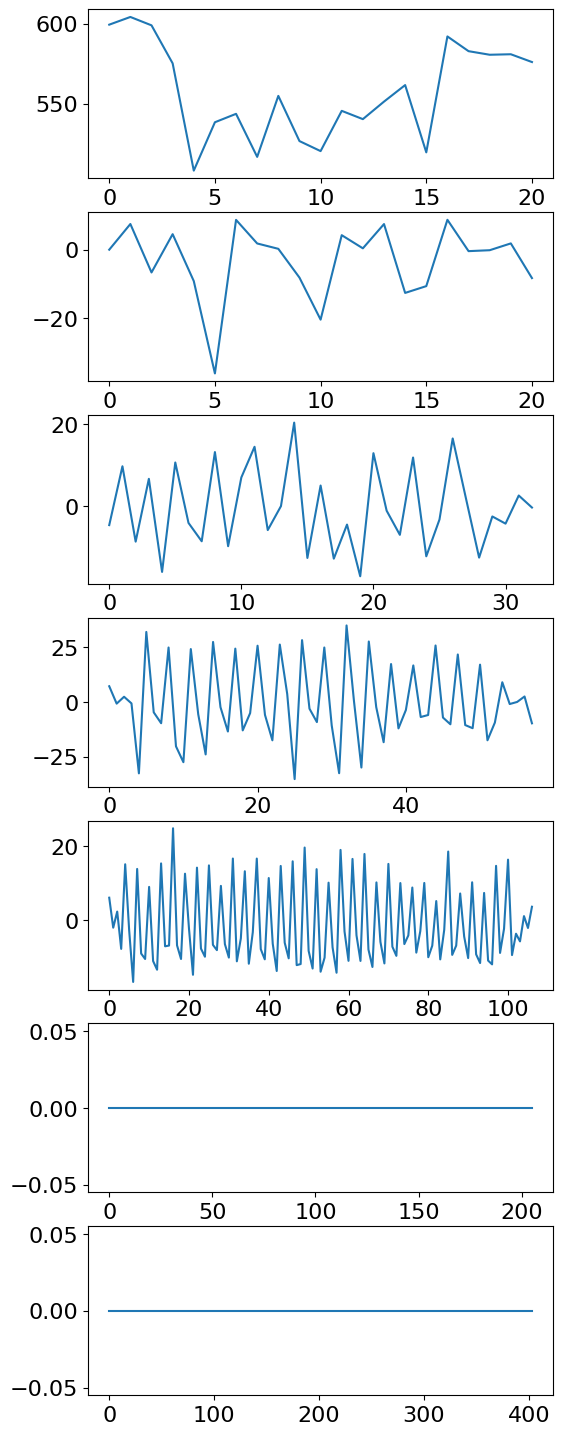

In [ ]:
# plot new coefficents

plt.figure(figsize=(6,18))

for i in range(len(coeffs)):
    plt.subplot(len(coeffs),1, i+1)
    plt.plot(coeffs[i])

In [ ]:
# reconstruct wavelet
y_rec = pywt.waverec(coeffs, 'sym5', mode='symmetric')[1:]

ValueError: ignored

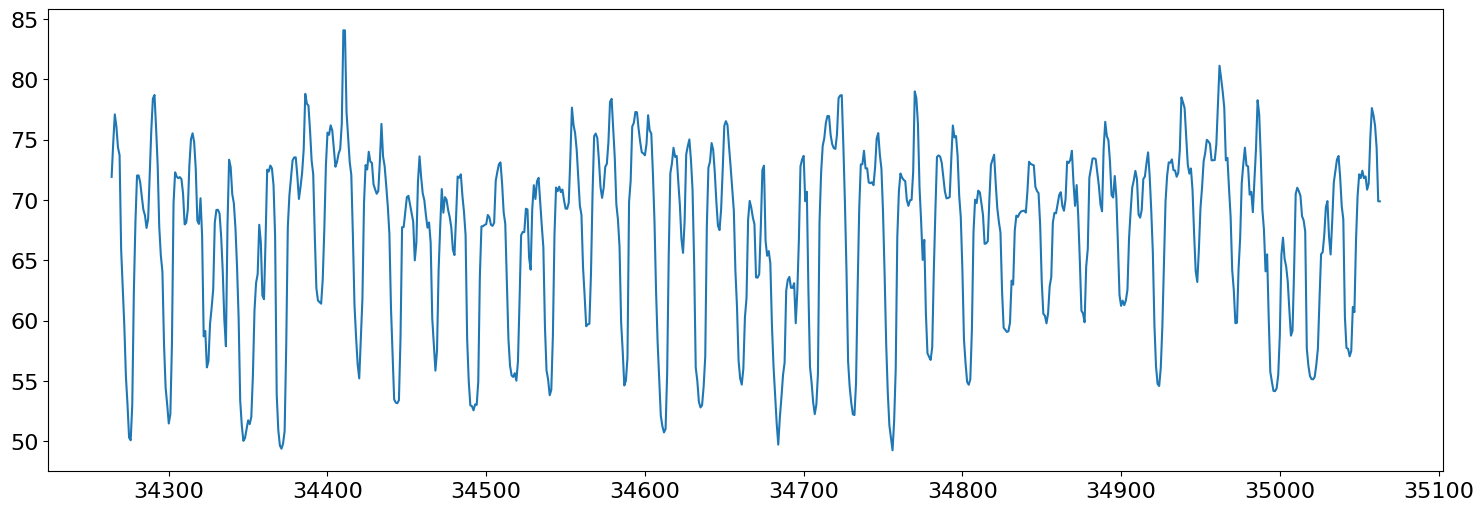

In [ ]:
# plot result
plt.figure(figsize=(18,6))
plt.plot(x, y)
plt.plot(x, y_rec)
plt.legend(['original', 'wavelet-based smoothing'])
plt.xlabel('time index')
plt.show()

In [ ]:
# CODE AUTHORED BY: SHAWHIN TALEBI

"""
    FUNCTION TO SMOOTH SIGNAL VIA WAVELET DECOMPOSITION

    INPUTS:
    - y = array-like signal to smooth

    OUTPUTS:
    - y_rec = smoothed version of input signal

    DEPENDENCIES:
    - PyWavelets 1.3.0
    - numpy 1.21.5
"""

import pywt
import numpy as np

def smooth_with_wavelets(y):

    # wavelet decomposition
    coeffs = pywt.wavedec(y, 'sym5', mode='symmetric')

    # zero out last 5 detail coefficents
    for i in range(5):
        coeffs[i+5] = np.zeros(coeffs[i+5].shape)

    # wavelet recomposition
    y_rec = pywt.waverec(coeffs, 'sym5', mode='symmetric')[1:]

    return y_rec

##### Using user defined function

In [ ]:
# smooth signal
y_smoothed = smooth_with_wavelets(y)

IndexError: ignored

ValueError: ignored

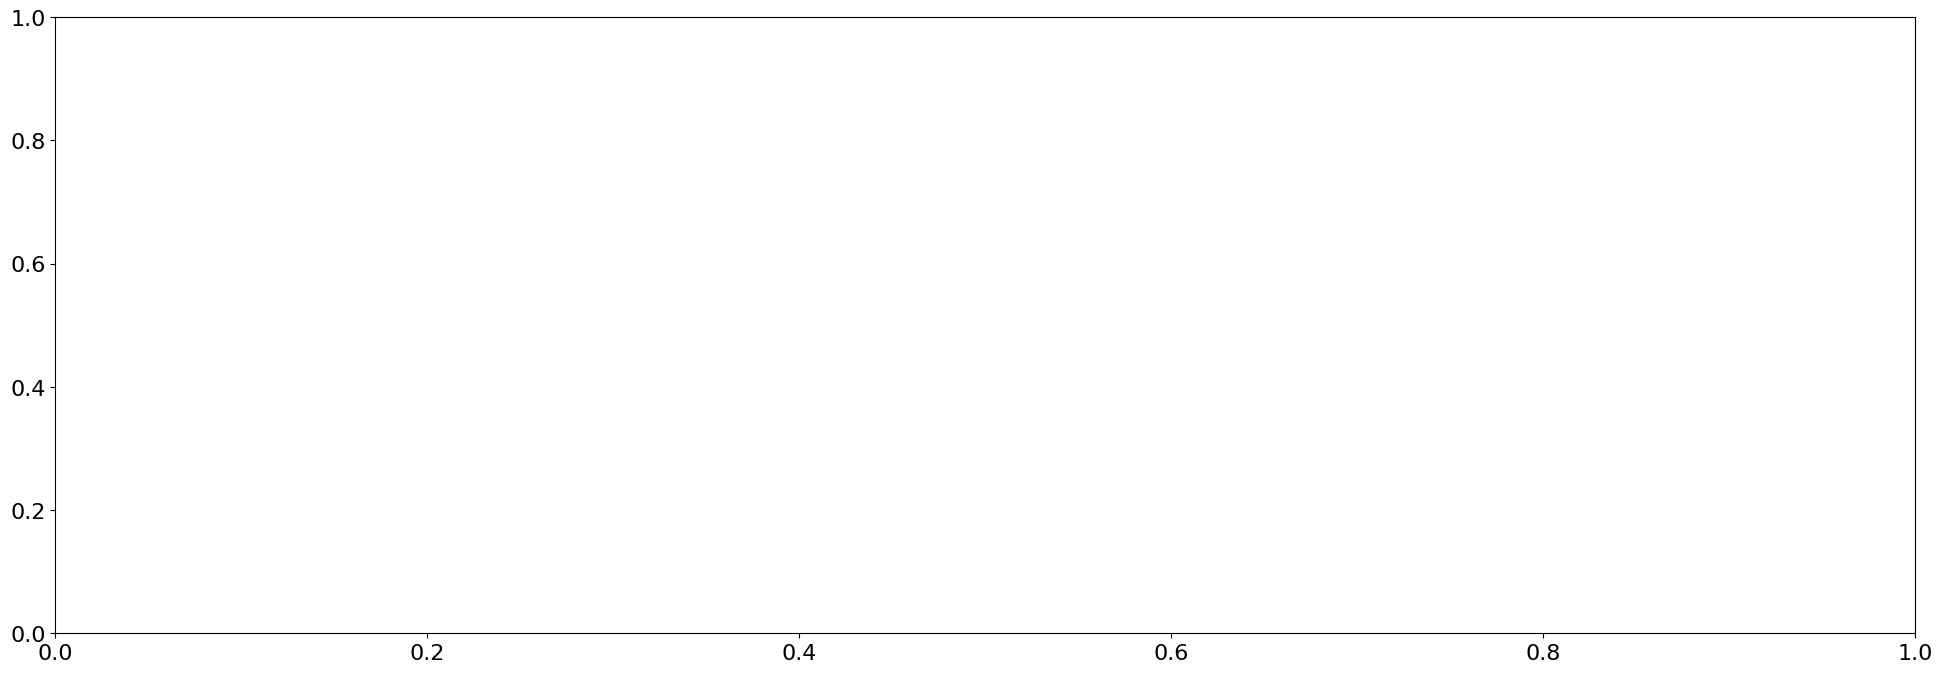

In [ ]:
# plot result
plt.figure(figsize=(24,8))
plt.rcParams.update({'font.size': 16})
plt.plot(x, y, x, y_smoothed, linewidth=2)
plt.legend(['original', 'smoothed'])
plt.savefig('smoothed_signal_plot.png', facecolor='white')
plt.show()

## What are your thoughts? How would you approach this problem?